# A04a: Filter Fundamentals

## Learning Objectives

By the end of this notebook, you will be able to:

- **Understand** the four basic filter types (lowpass, highpass, bandpass, notch)
- **Explain** key filter characteristics (cutoff frequency, order, transition band)
- **Compare** FIR and IIR filter designs and their trade-offs
- **Design** digital filters using scipy.signal functions
- **Visualize** filter frequency and phase responses

## Table of Contents

1. [Introduction](#section-1-introduction)
2. [Filter Types](#section-2-filter-types)
3. [Filter Characteristics](#section-3-filter-characteristics)
4. [Filter Order](#section-4-filter-order)
5. [FIR vs IIR Filters](#section-5-fir-vs-iir-filters)
6. [Designing Filters in Python](#section-6-designing-filters-in-python)
7. [Comparing Filter Designs](#section-7-comparing-filter-designs)
8. [Exercises](#section-8-exercises)
9. [Summary](#summary)
10. [External Resources](#external-resources)
11. [Discussion Questions](#discussion-questions)

---

In [1]:
# Standard library imports
import sys
from pathlib import Path
from typing import Tuple, Literal

# Third-party imports
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, cheby1, cheby2, ellip, firwin, freqz, lfilter

# Add src to path for local imports
src_path = Path.cwd().parent.parent.parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Local imports
from signals import generate_time_vector, generate_sine_wave
from colors import COLORS

# Matplotlib configuration
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 11

print(f"NumPy version: {np.__version__}")
print(f"Source path: {src_path}")

NumPy version: 2.3.5
Source path: /Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials/src


---

<a id="section-1-introduction"></a>
## 1. Introduction

Raw EEG signals are a mixture of many sources: neural activity from different brain regions, muscle artifacts (EMG), eye movements, cardiac activity, environmental noise (like 50/60 Hz power line interference), and slow drifts from electrode impedance changes. Before we can meaningfully analyze brain activity, we need to **filter** the signal to isolate the frequencies of interest.

Filtering is one of the most fundamental preprocessing steps in EEG analysis. When we say "alpha power increased during eyes-closed rest," we're specifically talking about the 8-13 Hz frequency range — and to measure that, we first need to remove activity outside this band. Similarly, connectivity measures like Phase Locking Value (PLV) or coherence are computed within specific frequency bands, so proper filtering is essential.

However, filtering is not without risks. Improper filtering can:
- **Distort signal timing** (phase distortion), which is catastrophic for phase-based connectivity
- **Create artifacts** at signal boundaries (edge effects)
- **Remove genuine brain activity** if cutoffs are too aggressive
- **Spread transient artifacts** across time (ringing)

In this notebook, we'll learn how filters work, how to design them properly, and understand the fundamentals before applying them in A04b.

---

<a id="section-2-filter-types"></a>
## 2. Filter Types

There are four basic types of frequency filters, each designed for a specific purpose:

### Low-pass Filter
Passes frequencies **below** the cutoff, attenuates frequencies above.  
**Use case**: Remove high-frequency noise, muscle artifacts (EMG), or prepare for downsampling.

### High-pass Filter
Passes frequencies **above** the cutoff, attenuates frequencies below.  
**Use case**: Remove slow drifts, baseline wander, and DC offset.

### Band-pass Filter
Passes frequencies **within** a range, attenuates frequencies outside.  
**Use case**: Isolate a specific frequency band (e.g., alpha 8-13 Hz) for analysis.

### Band-stop (Notch) Filter
Attenuates frequencies **within** a range, passes frequencies outside.  
**Use case**: Remove line noise (50 Hz in Europe, 60 Hz in Americas).

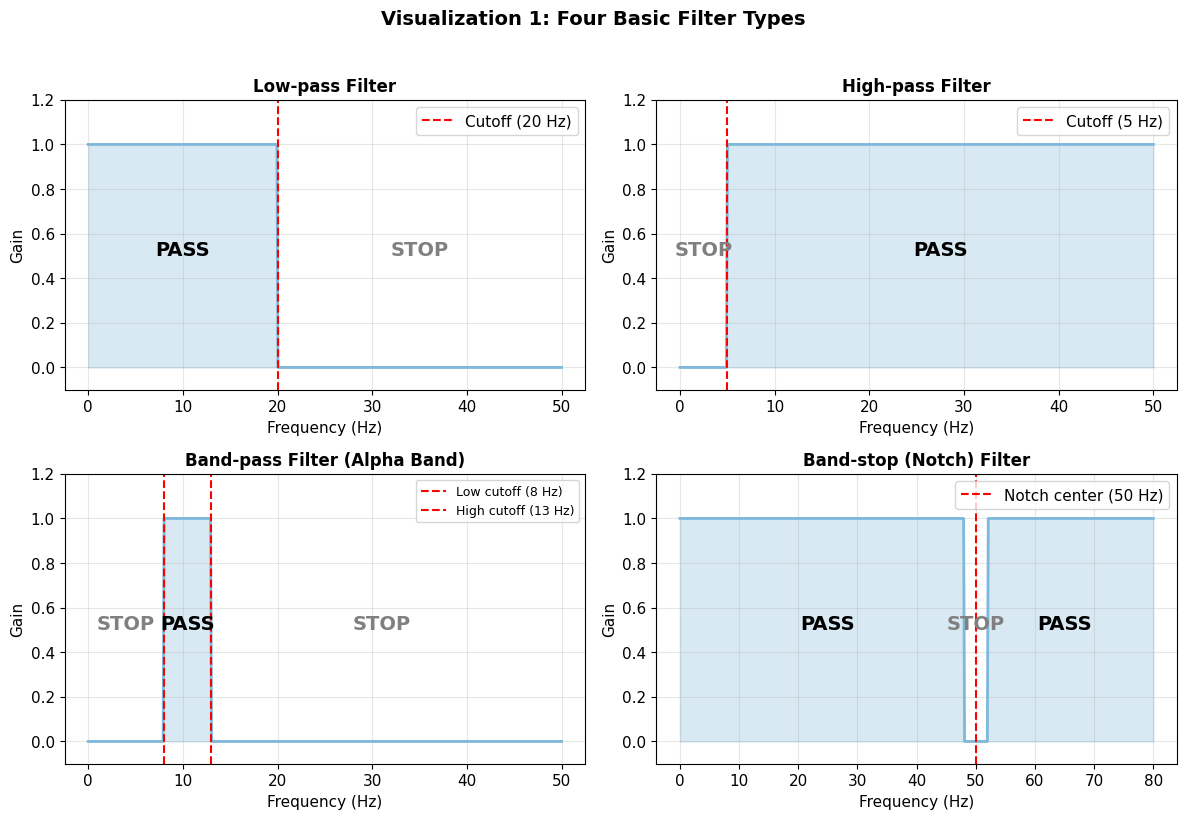

Note: These are IDEALIZED responses. Real filters have gradual transitions.


In [2]:
# ============================================================================
# VISUALIZATION 1: Four Filter Types (Idealized Frequency Response)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

freqs = np.linspace(0, 50, 500)

# Low-pass filter (cutoff at 20 Hz)
ax = axes[0, 0]
lowpass_response = np.where(freqs <= 20, 1, 0)
ax.fill_between(freqs, lowpass_response, alpha=0.3, color=COLORS["signal_1"])
ax.plot(freqs, lowpass_response, color=COLORS["signal_1"], linewidth=2)
ax.axvline(20, color="red", linestyle="--", linewidth=1.5, label="Cutoff (20 Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Gain")
ax.set_title("Low-pass Filter", fontsize=12, fontweight="bold")
ax.set_ylim(-0.1, 1.2)
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
ax.annotate("PASS", xy=(10, 0.5), fontsize=14, fontweight="bold", ha="center")
ax.annotate("STOP", xy=(35, 0.5), fontsize=14, fontweight="bold", ha="center", color="gray")

# High-pass filter (cutoff at 5 Hz)
ax = axes[0, 1]
highpass_response = np.where(freqs >= 5, 1, 0)
ax.fill_between(freqs, highpass_response, alpha=0.3, color=COLORS["signal_1"])
ax.plot(freqs, highpass_response, color=COLORS["signal_1"], linewidth=2)
ax.axvline(5, color="red", linestyle="--", linewidth=1.5, label="Cutoff (5 Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Gain")
ax.set_title("High-pass Filter", fontsize=12, fontweight="bold")
ax.set_ylim(-0.1, 1.2)
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
ax.annotate("STOP", xy=(2.5, 0.5), fontsize=14, fontweight="bold", ha="center", color="gray")
ax.annotate("PASS", xy=(27.5, 0.5), fontsize=14, fontweight="bold", ha="center")

# Band-pass filter (8-13 Hz alpha band)
ax = axes[1, 0]
bandpass_response = np.where((freqs >= 8) & (freqs <= 13), 1, 0)
ax.fill_between(freqs, bandpass_response, alpha=0.3, color=COLORS["signal_1"])
ax.plot(freqs, bandpass_response, color=COLORS["signal_1"], linewidth=2)
ax.axvline(8, color="red", linestyle="--", linewidth=1.5, label="Low cutoff (8 Hz)")
ax.axvline(13, color="red", linestyle="--", linewidth=1.5, label="High cutoff (13 Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Gain")
ax.set_title("Band-pass Filter (Alpha Band)", fontsize=12, fontweight="bold")
ax.set_ylim(-0.1, 1.2)
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3)
ax.annotate("STOP", xy=(4, 0.5), fontsize=14, fontweight="bold", ha="center", color="gray")
ax.annotate("PASS", xy=(10.5, 0.5), fontsize=14, fontweight="bold", ha="center")
ax.annotate("STOP", xy=(31, 0.5), fontsize=14, fontweight="bold", ha="center", color="gray")

# Band-stop (notch) filter (48-52 Hz to remove 50 Hz line noise)
ax = axes[1, 1]
notch_freqs = np.linspace(0, 80, 500)
notch_response = np.where((notch_freqs >= 48) & (notch_freqs <= 52), 0, 1)
ax.fill_between(notch_freqs, notch_response, alpha=0.3, color=COLORS["signal_1"])
ax.plot(notch_freqs, notch_response, color=COLORS["signal_1"], linewidth=2)
ax.axvline(50, color="red", linestyle="--", linewidth=1.5, label="Notch center (50 Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Gain")
ax.set_title("Band-stop (Notch) Filter", fontsize=12, fontweight="bold")
ax.set_ylim(-0.1, 1.2)
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
ax.annotate("PASS", xy=(25, 0.5), fontsize=14, fontweight="bold", ha="center")
ax.annotate("STOP", xy=(50, 0.5), fontsize=14, fontweight="bold", ha="center", color="gray")
ax.annotate("PASS", xy=(65, 0.5), fontsize=14, fontweight="bold", ha="center")

plt.suptitle("Visualization 1: Four Basic Filter Types", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print("Note: These are IDEALIZED responses. Real filters have gradual transitions.")

---

<a id="section-3-filter-characteristics"></a>
## 3. Filter Characteristics

Every filter is defined by several key characteristics that determine its behavior:

### Key Parameters

| Parameter | Description | Unit |
|-----------|-------------|------|
| **Cutoff frequency (fc)** | Frequency where the filter starts attenuating | Hz |
| **Passband** | Frequency range where signals pass through | Hz |
| **Stopband** | Frequency range where signals are blocked | Hz |
| **Transition band** | Region between passband and stopband | Hz |
| **Passband ripple** | Amplitude variation in the passband | dB |
| **Stopband attenuation** | How much the stopband is suppressed | dB |
| **Filter order** | Number of coefficients (affects sharpness) | - |

### The -3 dB Point

The cutoff frequency is typically defined as the **-3 dB point**, where the signal power is reduced to half (amplitude to ~70.7%).

$$P_{-3dB} = \frac{P_{max}}{2} \quad \Rightarrow \quad A_{-3dB} = \frac{A_{max}}{\sqrt{2}} \approx 0.707 \cdot A_{max}$$

Let's visualize these characteristics:

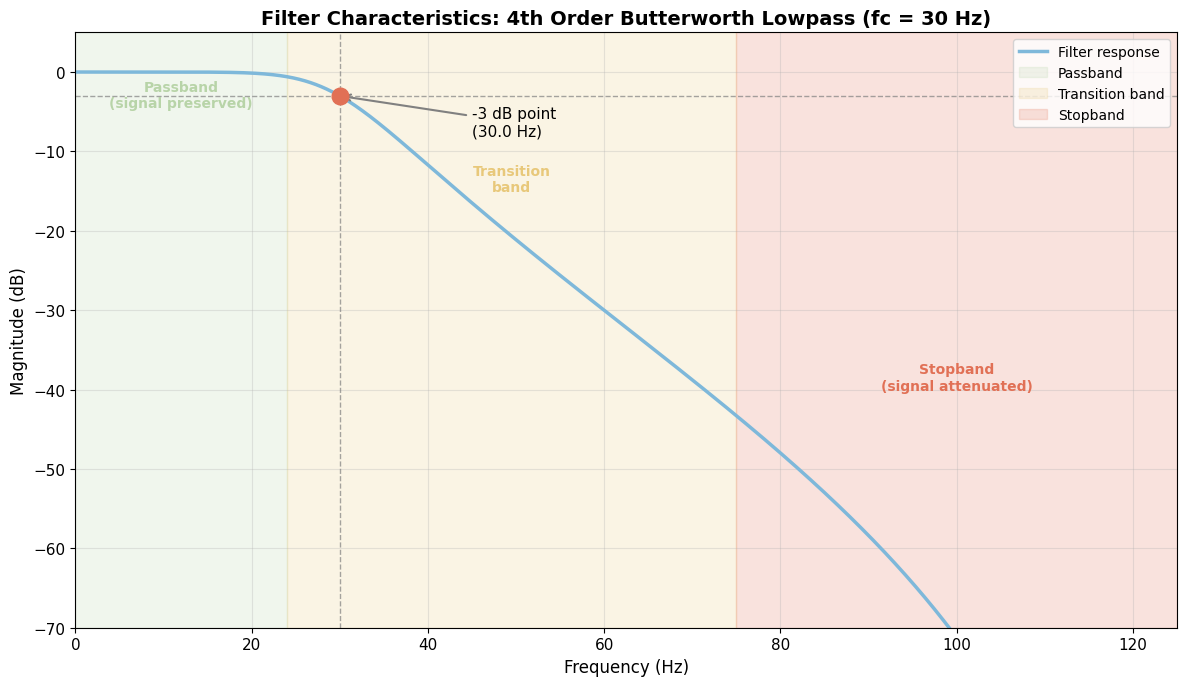

✓ Cutoff frequency: 30 Hz
✓ -3 dB point: 30.0 Hz
✓ Filter order: 4
✓ Stopband attenuation: ~81 dB


In [3]:
# ============================================================================
# VISUALIZATION 2: Annotated Filter Response with Key Characteristics
# ============================================================================

# Design a 4th order Butterworth lowpass filter
order = 4
cutoff_freq = 30  # Hz
fs = 250  # Sampling frequency
nyquist = fs / 2
normalized_cutoff = cutoff_freq / nyquist

# Get filter coefficients
b, a = butter(order, normalized_cutoff, btype='low')

# Compute frequency response
w, h = freqz(b, a, worN=2048)
frequencies = w * nyquist / np.pi
magnitude_db = 20 * np.log10(np.abs(h) + 1e-10)

# Create annotated visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot frequency response
ax.plot(frequencies, magnitude_db, color=COLORS["signal_1"], linewidth=2.5, label='Filter response')

# Find -3dB point
db_3_idx = np.argmin(np.abs(magnitude_db - (-3)))
freq_3db = frequencies[db_3_idx]

# Define regions
passband_end = cutoff_freq * 0.8
stopband_start = cutoff_freq * 2.5

# Shade regions
ax.axvspan(0, passband_end, alpha=0.2, color=COLORS["signal_3"], label='Passband')
ax.axvspan(passband_end, stopband_start, alpha=0.2, color=COLORS["signal_4"], label='Transition band')
ax.axvspan(stopband_start, nyquist, alpha=0.2, color=COLORS["negative"], label='Stopband')

# Mark -3dB point
ax.axhline(y=-3, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.axvline(x=freq_3db, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.plot(freq_3db, -3, 'o', color=COLORS["negative"], markersize=12, zorder=5)
ax.annotate(f'-3 dB point\n({freq_3db:.1f} Hz)', 
            xy=(freq_3db, -3), xytext=(freq_3db + 15, -8),
            fontsize=11, ha='left',
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Add annotations for regions
ax.annotate('Passband\n(signal preserved)', xy=(passband_end/2, -1), fontsize=10, 
            ha='center', va='top', color=COLORS["signal_3"], fontweight='bold')
ax.annotate('Transition\nband', xy=((passband_end + stopband_start)/2, -15), fontsize=10,
            ha='center', color=COLORS["signal_4"], fontweight='bold')
ax.annotate('Stopband\n(signal attenuated)', xy=((stopband_start + nyquist)/2, -40), fontsize=10,
            ha='center', color=COLORS["negative"], fontweight='bold')

# Add stopband attenuation annotation
min_atten = magnitude_db[frequencies > stopband_start].mean()
ax.annotate(f'Stopband attenuation\n≈ {abs(min_atten):.0f} dB', 
            xy=(100, min_atten), xytext=(80, -55),
            fontsize=10, ha='center',
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Magnitude (dB)', fontsize=12)
ax.set_title(f'Filter Characteristics: {order}th Order Butterworth Lowpass (fc = {cutoff_freq} Hz)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(0, nyquist)
ax.set_ylim(-70, 5)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Cutoff frequency: {cutoff_freq} Hz")
print(f"✓ -3 dB point: {freq_3db:.1f} Hz")
print(f"✓ Filter order: {order}")
print(f"✓ Stopband attenuation: ~{abs(min_atten):.0f} dB")

---

<a id="section-4-filter-order"></a>
## 4. Filter Order

The **filter order** determines how sharply the filter transitions from passband to stopband:

- **Higher order** → Sharper transition, but more computation and potential instability
- **Lower order** → Gentler transition, but more robust and faster

Let's compare different filter orders:

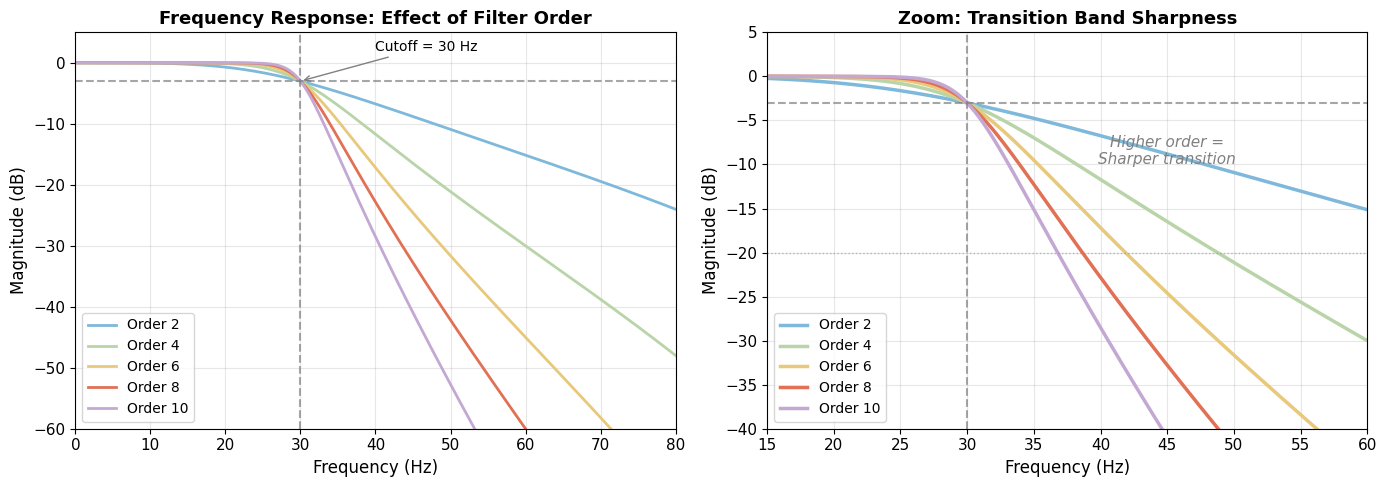

Transition band width (from -3 dB to -20 dB):
----------------------------------------
Order  2:  41.3 Hz  (30.0 → 71.3 Hz)
Order  4:  18.8 Hz  (30.0 → 48.8 Hz)
Order  6:  11.9 Hz  (30.0 → 41.9 Hz)
Order  8:   8.6 Hz  (30.0 → 38.6 Hz)
Order 10:   6.8 Hz  (30.0 → 36.8 Hz)


In [4]:
# ============================================================================
# VISUALIZATION 3: Effect of Filter Order on Frequency Response
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Parameters
cutoff_freq = 30  # Hz
fs = 250
nyquist = fs / 2
normalized_cutoff = cutoff_freq / nyquist
orders = [2, 4, 6, 8, 10]
colors = [COLORS["signal_1"], COLORS["signal_3"], COLORS["signal_4"], COLORS["negative"], COLORS["signal_5"]]

# Left plot: Frequency response comparison
ax1 = axes[0]
for order, color in zip(orders, colors):
    b, a = butter(order, normalized_cutoff, btype='low')
    w, h = freqz(b, a, worN=2048)
    freqs = w * nyquist / np.pi
    mag_db = 20 * np.log10(np.abs(h) + 1e-10)
    ax1.plot(freqs, mag_db, color=color, linewidth=2, label=f'Order {order}')

# Mark cutoff frequency
ax1.axvline(x=cutoff_freq, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.axhline(y=-3, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

ax1.set_xlabel('Frequency (Hz)', fontsize=12)
ax1.set_ylabel('Magnitude (dB)', fontsize=12)
ax1.set_title('Frequency Response: Effect of Filter Order', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 80)
ax1.set_ylim(-60, 5)
ax1.legend(loc='lower left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Add annotation
ax1.annotate(f'Cutoff = {cutoff_freq} Hz', xy=(cutoff_freq, -3), xytext=(cutoff_freq + 10, 2),
             fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))

# Right plot: Zoom on transition band
ax2 = axes[1]
for order, color in zip(orders, colors):
    b, a = butter(order, normalized_cutoff, btype='low')
    w, h = freqz(b, a, worN=2048)
    freqs = w * nyquist / np.pi
    mag_db = 20 * np.log10(np.abs(h) + 1e-10)
    ax2.plot(freqs, mag_db, color=color, linewidth=2.5, label=f'Order {order}')

ax2.axvline(x=cutoff_freq, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axhline(y=-3, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axhline(y=-20, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude (dB)', fontsize=12)
ax2.set_title('Zoom: Transition Band Sharpness', fontsize=13, fontweight='bold')
ax2.set_xlim(15, 60)
ax2.set_ylim(-40, 5)
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Add annotation about transition width
ax2.annotate('Higher order =\nSharper transition', xy=(45, -10), fontsize=11,
             ha='center', style='italic', color='gray')

plt.tight_layout()
plt.show()

# Calculate transition band width for each order
print("Transition band width (from -3 dB to -20 dB):")
print("-" * 40)
for order, color in zip(orders, colors):
    b, a = butter(order, normalized_cutoff, btype='low')
    w, h = freqz(b, a, worN=4096)
    freqs = w * nyquist / np.pi
    mag_db = 20 * np.log10(np.abs(h) + 1e-10)
    
    # Find -3dB and -20dB points
    idx_3db = np.argmin(np.abs(mag_db - (-3)))
    idx_20db = np.argmin(np.abs(mag_db - (-20)))
    
    freq_3db = freqs[idx_3db]
    freq_20db = freqs[idx_20db]
    transition_width = freq_20db - freq_3db
    
    print(f"Order {order:2d}: {transition_width:5.1f} Hz  ({freq_3db:.1f} → {freq_20db:.1f} Hz)")

---

<a id="section-5-fir-vs-iir-filters"></a>
## 5. FIR vs IIR Filters

There are two main categories of digital filters, each with distinct characteristics:

### FIR: Finite Impulse Response

The output depends only on the **current and past input values**:

$$y[n] = \sum_{k=0}^{M} b_k \cdot x[n-k]$$

### IIR: Infinite Impulse Response

The output depends on **past inputs AND past outputs** (feedback):

$$y[n] = \sum_{k=0}^{M} b_k \cdot x[n-k] - \sum_{k=1}^{N} a_k \cdot y[n-k]$$

### Comparison Table

| Characteristic | FIR | IIR |
|----------------|-----|-----|
| **Stability** | Always stable | Can be unstable |
| **Phase response** | Can be linear (no distortion) | Non-linear phase |
| **Filter order** | Higher order needed | Lower order sufficient |
| **Computation** | More coefficients | Fewer coefficients |
| **Memory** | No feedback | Requires feedback |
| **Typical use** | When phase matters | When efficiency matters |

### For EEG Analysis

- **FIR filters** are preferred when **phase relationships** matter (connectivity analysis)
- **IIR filters** (like Butterworth) are common for **general preprocessing**
- **Zero-phase filtering** (filtfilt) can eliminate phase distortion for both types

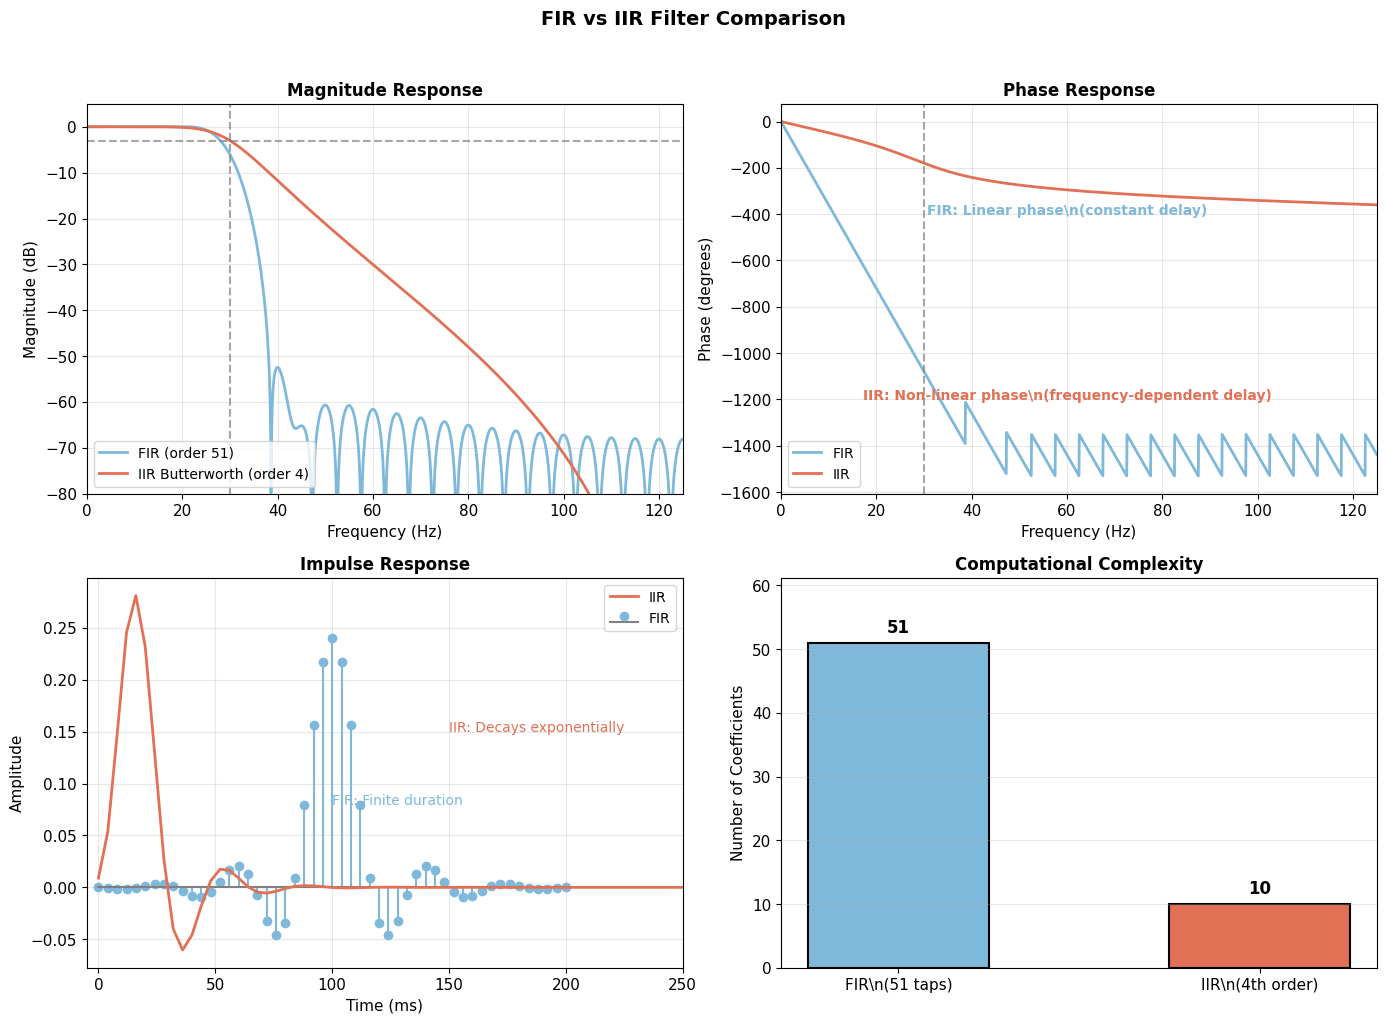

Summary:
  FIR filter: 51 coefficients, linear phase, always stable
  IIR filter: 10 coefficients, non-linear phase, can be unstable


In [5]:
# ============================================================================
# VISUALIZATION 4: FIR vs IIR Filter Comparison
# ============================================================================

# Parameters
fs = 250
nyquist = fs / 2
cutoff = 30
duration = 1.0
t = np.arange(0, duration, 1/fs)

# Create test signal: sum of frequencies
np.random.seed(42)
signal_clean = (np.sin(2 * np.pi * 10 * t) +      # 10 Hz (alpha) - to keep
                0.5 * np.sin(2 * np.pi * 25 * t) + # 25 Hz (beta) - to keep
                0.3 * np.sin(2 * np.pi * 50 * t))  # 50 Hz - to remove

# Design FIR filter (using firwin)
fir_order = 51  # Number of taps
fir_coeffs = firwin(fir_order, cutoff / nyquist, window='hamming')

# Design IIR filter (Butterworth)
iir_order = 4
b_iir, a_iir = butter(iir_order, cutoff / nyquist, btype='low')

# Get frequency responses
w_fir, h_fir = freqz(fir_coeffs, 1, worN=2048)
w_iir, h_iir = freqz(b_iir, a_iir, worN=2048)
freqs_fir = w_fir * nyquist / np.pi
freqs_iir = w_iir * nyquist / np.pi

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Magnitude response comparison
ax1 = axes[0, 0]
ax1.plot(freqs_fir, 20 * np.log10(np.abs(h_fir) + 1e-10), 
         color=COLORS["signal_1"], linewidth=2, label=f'FIR (order {fir_order})')
ax1.plot(freqs_iir, 20 * np.log10(np.abs(h_iir) + 1e-10), 
         color=COLORS["negative"], linewidth=2, label=f'IIR Butterworth (order {iir_order})')
ax1.axvline(x=cutoff, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.axhline(y=-3, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.set_xlabel('Frequency (Hz)', fontsize=11)
ax1.set_ylabel('Magnitude (dB)', fontsize=11)
ax1.set_title('Magnitude Response', fontsize=12, fontweight='bold')
ax1.set_xlim(0, nyquist)
ax1.set_ylim(-80, 5)
ax1.legend(loc='lower left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Phase response comparison
ax2 = axes[0, 1]
phase_fir = np.unwrap(np.angle(h_fir))
phase_iir = np.unwrap(np.angle(h_iir))
ax2.plot(freqs_fir, np.degrees(phase_fir), color=COLORS["signal_1"], linewidth=2, label='FIR')
ax2.plot(freqs_iir, np.degrees(phase_iir), color=COLORS["negative"], linewidth=2, label='IIR')
ax2.axvline(x=cutoff, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('Frequency (Hz)', fontsize=11)
ax2.set_ylabel('Phase (degrees)', fontsize=11)
ax2.set_title('Phase Response', fontsize=12, fontweight='bold')
ax2.set_xlim(0, nyquist)
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.annotate('FIR: Linear phase\\n(constant delay)', xy=(60, -400), fontsize=10,
             ha='center', color=COLORS["signal_1"], fontweight='bold')
ax2.annotate('IIR: Non-linear phase\\n(frequency-dependent delay)', xy=(60, -1200), fontsize=10,
             ha='center', color=COLORS["negative"], fontweight='bold')

# Plot 3: Impulse response
ax3 = axes[1, 0]
# FIR impulse response is just the coefficients
fir_impulse = fir_coeffs
fir_time = np.arange(len(fir_impulse)) / fs * 1000  # ms

# IIR impulse response (apply to impulse)
impulse = np.zeros(100)
impulse[0] = 1
iir_impulse = lfilter(b_iir, a_iir, impulse)
iir_time = np.arange(len(iir_impulse)) / fs * 1000  # ms

ax3.stem(fir_time, fir_impulse, linefmt=COLORS["signal_1"], markerfmt='o', basefmt='gray', 
         label='FIR')
ax3.plot(iir_time, iir_impulse, color=COLORS["negative"], linewidth=2, label='IIR')
ax3.set_xlabel('Time (ms)', fontsize=11)
ax3.set_ylabel('Amplitude', fontsize=11)
ax3.set_title('Impulse Response', fontsize=12, fontweight='bold')
ax3.set_xlim(-5, 250)
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.annotate('FIR: Finite duration', xy=(100, 0.08), fontsize=10, color=COLORS["signal_1"])
ax3.annotate('IIR: Decays exponentially', xy=(150, 0.15), fontsize=10, color=COLORS["negative"])

# Plot 4: Filter coefficients count
ax4 = axes[1, 1]
categories = ['FIR\\n(51 taps)', 'IIR\\n(4th order)']
fir_count = len(fir_coeffs)
iir_count = len(b_iir) + len(a_iir)  # b and a coefficients
counts = [fir_count, iir_count]
colors_bar = [COLORS["signal_1"], COLORS["negative"]]

bars = ax4.bar(categories, counts, color=colors_bar, width=0.5, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Number of Coefficients', fontsize=11)
ax4.set_title('Computational Complexity', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars, counts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

ax4.set_ylim(0, max(counts) * 1.2)

plt.suptitle('FIR vs IIR Filter Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Summary:")
print(f"  FIR filter: {fir_count} coefficients, linear phase, always stable")
print(f"  IIR filter: {iir_count} coefficients, non-linear phase, can be unstable")

---

<a id="section-6-designing-filters-in-python"></a>
## 6. Designing Filters in Python

Now let's learn how to design filters using `scipy.signal`. We'll create reusable functions that are in our `src/filtering.py` module.

### Key scipy.signal Functions

| Function | Purpose | Filter Type |
|----------|---------|-------------|
| `butter()` | Butterworth filter design | IIR |
| `cheby1()` | Chebyshev Type I | IIR |
| `cheby2()` | Chebyshev Type II | IIR |
| `ellip()` | Elliptic filter | IIR |
| `firwin()` | FIR filter with window method | FIR |
| `firwin2()` | FIR with arbitrary frequency response | FIR |
| `iirnotch()` | Notch filter design | IIR |

### Design Functions

Let's implement wrapper functions for common filter designs:

In [6]:
# ============================================================================
# Filter Design Functions (from src/filtering.py)
# ============================================================================

def design_iir_filter(
    cutoff: float | Tuple[float, float],
    fs: float,
    order: int = 4,
    btype: Literal['low', 'high', 'band', 'bandstop'] = 'low',
    ftype: Literal['butter', 'cheby1', 'cheby2', 'ellip'] = 'butter',
    rp: float = 1.0,
    rs: float = 40.0
) -> Tuple[NDArray[np.floating], NDArray[np.floating]]:
    """
    Design an IIR filter.
    
    Parameters
    ----------
    cutoff : float or tuple of float
        Cutoff frequency in Hz. For bandpass/bandstop, provide (low, high).
    fs : float
        Sampling frequency in Hz.
    order : int, default=4
        Filter order.
    btype : {'low', 'high', 'band', 'bandstop'}, default='low'
        Filter type.
    ftype : {'butter', 'cheby1', 'cheby2', 'ellip'}, default='butter'
        IIR filter family.
    rp : float, default=1.0
        Maximum ripple in passband (dB). Used for cheby1 and ellip.
    rs : float, default=40.0
        Minimum attenuation in stopband (dB). Used for cheby2 and ellip.
    
    Returns
    -------
    b : ndarray
        Numerator coefficients.
    a : ndarray
        Denominator coefficients.
    """
    nyquist = fs / 2
    
    # Normalize cutoff frequency
    if isinstance(cutoff, (list, tuple)):
        normalized_cutoff = (cutoff[0] / nyquist, cutoff[1] / nyquist)
    else:
        normalized_cutoff = cutoff / nyquist
    
    # Select filter design function
    if ftype == 'butter':
        b, a = butter(order, normalized_cutoff, btype=btype)
    elif ftype == 'cheby1':
        b, a = cheby1(order, rp, normalized_cutoff, btype=btype)
    elif ftype == 'cheby2':
        b, a = cheby2(order, rs, normalized_cutoff, btype=btype)
    elif ftype == 'ellip':
        b, a = ellip(order, rp, rs, normalized_cutoff, btype=btype)
    else:
        raise ValueError(f"Unknown filter type: {ftype}")
    
    return b, a


def design_fir_filter(
    cutoff: float | Tuple[float, float],
    fs: float,
    numtaps: int = 101,
    btype: Literal['low', 'high', 'band', 'bandstop'] = 'low',
    window: str = 'hamming'
) -> NDArray[np.floating]:
    """
    Design a FIR filter using the window method.
    
    Parameters
    ----------
    cutoff : float or tuple of float
        Cutoff frequency in Hz. For bandpass/bandstop, provide (low, high).
    fs : float
        Sampling frequency in Hz.
    numtaps : int, default=101
        Number of filter coefficients (filter length).
    btype : {'low', 'high', 'band', 'bandstop'}, default='low'
        Filter type.
    window : str, default='hamming'
        Window function to use.
    
    Returns
    -------
    h : ndarray
        FIR filter coefficients.
    """
    nyquist = fs / 2
    
    # Normalize cutoff frequency
    if isinstance(cutoff, (list, tuple)):
        normalized_cutoff = [c / nyquist for c in cutoff]
    else:
        normalized_cutoff = cutoff / nyquist
    
    # Design filter
    if btype == 'low':
        h = firwin(numtaps, normalized_cutoff, window=window)
    elif btype == 'high':
        h = firwin(numtaps, normalized_cutoff, pass_zero=False, window=window)
    elif btype == 'band':
        h = firwin(numtaps, normalized_cutoff, pass_zero=False, window=window)
    elif btype == 'bandstop':
        h = firwin(numtaps, normalized_cutoff, pass_zero=True, window=window)
    else:
        raise ValueError(f"Unknown filter type: {btype}")
    
    return h


# Test the design functions
print("Testing filter design functions:")
print("=" * 50)

# Test IIR designs
b_butter, a_butter = design_iir_filter(30, fs=250, order=4, btype='low', ftype='butter')
print(f"✓ Butterworth lowpass: {len(b_butter)} b coeffs, {len(a_butter)} a coeffs")

b_band, a_band = design_iir_filter((8, 13), fs=250, order=4, btype='band', ftype='butter')
print(f"✓ Butterworth bandpass: {len(b_band)} b coeffs, {len(a_band)} a coeffs")

# Test FIR designs
h_fir_low = design_fir_filter(30, fs=250, numtaps=101, btype='low')
print(f"✓ FIR lowpass: {len(h_fir_low)} taps")

h_fir_band = design_fir_filter((8, 13), fs=250, numtaps=101, btype='band')
print(f"✓ FIR bandpass: {len(h_fir_band)} taps")

Testing filter design functions:
✓ Butterworth lowpass: 5 b coeffs, 5 a coeffs
✓ Butterworth bandpass: 9 b coeffs, 9 a coeffs
✓ FIR lowpass: 101 taps
✓ FIR bandpass: 101 taps


---

<a id="section-7-comparing-filter-designs"></a>
## 7. Comparing Filter Designs

Let's visualize different IIR filter types (Butterworth, Chebyshev, Elliptic):

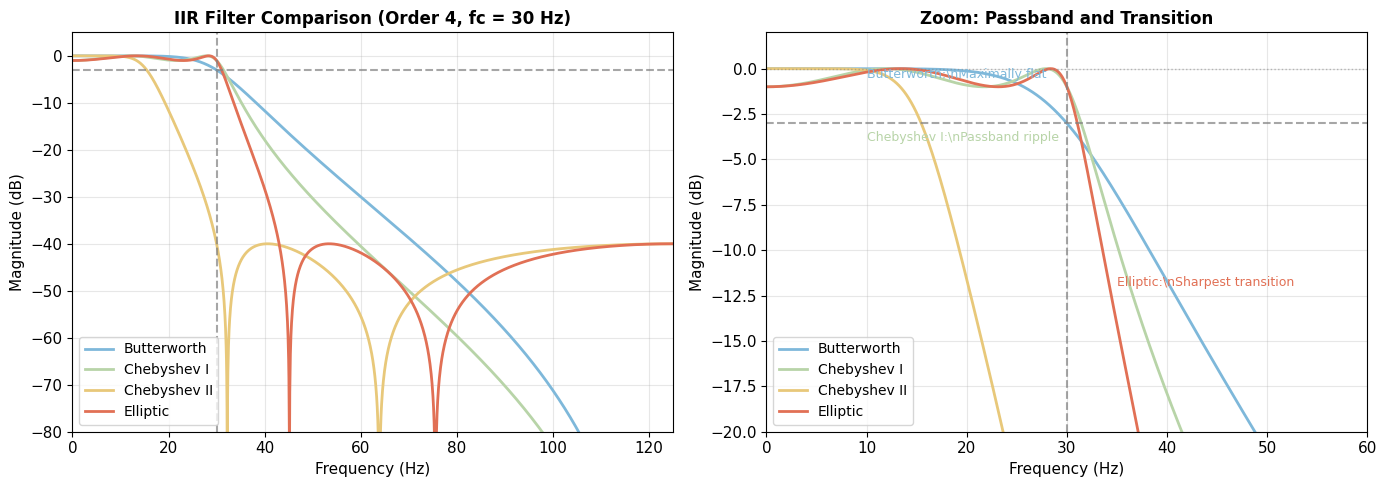

Filter Characteristics Summary:
------------------------------------------------------------
Butterworth  : Maximally flat passband, gentle transition
Chebyshev I  : Ripple in passband, sharper transition
Chebyshev II : Flat passband, ripple in stopband
Elliptic     : Sharpest transition, ripple in both bands


In [7]:
# ============================================================================
# VISUALIZATION 5: Comparing Different IIR Filter Designs
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Parameters
cutoff = 30  # Hz
fs = 250
order = 4
filter_types = ['butter', 'cheby1', 'cheby2', 'ellip']
colors = [COLORS["signal_1"], COLORS["signal_3"], COLORS["signal_4"], COLORS["negative"]]
labels = ['Butterworth', 'Chebyshev I', 'Chebyshev II', 'Elliptic']

# Left plot: Full frequency response
ax1 = axes[0]
for ftype, color, label in zip(filter_types, colors, labels):
    b, a = design_iir_filter(cutoff, fs=fs, order=order, btype='low', ftype=ftype)
    w, h = freqz(b, a, worN=2048)
    freqs = w * (fs/2) / np.pi
    mag_db = 20 * np.log10(np.abs(h) + 1e-10)
    ax1.plot(freqs, mag_db, color=color, linewidth=2, label=label)

ax1.axvline(x=cutoff, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.axhline(y=-3, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.set_xlabel('Frequency (Hz)', fontsize=11)
ax1.set_ylabel('Magnitude (dB)', fontsize=11)
ax1.set_title(f'IIR Filter Comparison (Order {order}, fc = {cutoff} Hz)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, fs/2)
ax1.set_ylim(-80, 5)
ax1.legend(loc='lower left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: Zoom on passband ripple
ax2 = axes[1]
for ftype, color, label in zip(filter_types, colors, labels):
    b, a = design_iir_filter(cutoff, fs=fs, order=order, btype='low', ftype=ftype)
    w, h = freqz(b, a, worN=2048)
    freqs = w * (fs/2) / np.pi
    mag_db = 20 * np.log10(np.abs(h) + 1e-10)
    ax2.plot(freqs, mag_db, color=color, linewidth=2, label=label)

ax2.axvline(x=cutoff, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axhline(y=-3, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax2.set_xlabel('Frequency (Hz)', fontsize=11)
ax2.set_ylabel('Magnitude (dB)', fontsize=11)
ax2.set_title('Zoom: Passband and Transition', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 60)
ax2.set_ylim(-20, 2)
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Add annotations
ax2.annotate('Butterworth:\\nMaximally flat', xy=(10, -0.5), fontsize=9, color=COLORS["signal_1"])
ax2.annotate('Chebyshev I:\\nPassband ripple', xy=(10, -4), fontsize=9, color=COLORS["signal_3"])
ax2.annotate('Elliptic:\\nSharpest transition', xy=(35, -12), fontsize=9, color=COLORS["negative"])

plt.tight_layout()
plt.show()

print("Filter Characteristics Summary:")
print("-" * 60)
print("Butterworth  : Maximally flat passband, gentle transition")
print("Chebyshev I  : Ripple in passband, sharper transition")
print("Chebyshev II : Flat passband, ripple in stopband")
print("Elliptic     : Sharpest transition, ripple in both bands")

---

<a id="section-8-exercises"></a>
## 8. Exercises

### 🎯 Exercise 1: Design a Custom Beta Filter

**Task:** Design a bandpass filter for the beta band (13-30 Hz) with:
- Order 6 Butterworth IIR filter
- Visualize the frequency response
- Verify the -3 dB points are near 13 and 30 Hz

```python
# Your code here
fs = 250

# Design order 6 Butterworth bandpass for beta (13-30 Hz)
# b, a = design_iir_filter(cutoff=(???, ???), fs=fs, order=???, btype='band')

# Plot frequency response
# ...
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
fs = 250

# Design order 6 Butterworth bandpass for beta (13-30 Hz)
b, a = design_iir_filter(cutoff=(13, 30), fs=fs, order=6, btype='band', ftype='butter')

# Plot frequency response
fig, ax = plt.subplots(figsize=(12, 5))
w, h = freqz(b, a, worN=2048)
freqs = w * (fs/2) / np.pi
mag_db = 20 * np.log10(np.abs(h) + 1e-10)

ax.plot(freqs, mag_db, color=COLORS["signal_1"], linewidth=2)
ax.axvline(x=13, color=COLORS["negative"], linestyle='--', label='13 Hz')
ax.axvline(x=30, color=COLORS["negative"], linestyle='--', label='30 Hz')
ax.axhline(y=-3, color='gray', linestyle='--', alpha=0.5)
ax.axvspan(13, 30, alpha=0.2, color=COLORS["signal_3"], label='Beta band')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Beta Band Filter Response (Order 6)')
ax.set_xlim(0, 60)
ax.set_ylim(-60, 5)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find -3dB points
idx_low = np.argmin(np.abs(mag_db[:len(mag_db)//2] - (-3)))
idx_high = np.argmin(np.abs(mag_db[len(mag_db)//2:] - (-3))) + len(mag_db)//2
print(f"Low -3dB point: {freqs[idx_low]:.1f} Hz")
print(f"High -3dB point: {freqs[idx_high]:.1f} Hz")
```

</details>

### 🎯 Exercise 2: Compare FIR and IIR Efficiency

**Task:** Compare a FIR and IIR filter that achieve similar frequency responses:
- Design both to lowpass at 40 Hz
- Compare the number of coefficients needed
- Visualize their magnitude responses

```python
# Your code here
fs = 250
cutoff = 40

# Design IIR (order 4)
# b_iir, a_iir = design_iir_filter(???)

# Design FIR (numtaps 101)
# h_fir = design_fir_filter(???)

# Compare responses
# ...
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
fs = 250
cutoff = 40

# Design IIR (order 4)
b_iir, a_iir = design_iir_filter(cutoff, fs, order=4, btype='low')

# Design FIR (numtaps 101)
h_fir = design_fir_filter(cutoff, fs, numtaps=101, btype='low')

# Get frequency responses
w_iir, h_resp_iir = freqz(b_iir, a_iir, worN=2048)
w_fir, h_resp_fir = freqz(h_fir, 1, worN=2048)
freqs = w_iir * (fs/2) / np.pi

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Magnitude response
ax1 = axes[0]
ax1.plot(freqs, 20 * np.log10(np.abs(h_resp_iir) + 1e-10), 
         color=COLORS["negative"], linewidth=2, label=f'IIR ({len(b_iir) + len(a_iir)} coeffs)')
ax1.plot(freqs, 20 * np.log10(np.abs(h_resp_fir) + 1e-10), 
         color=COLORS["signal_1"], linewidth=2, label=f'FIR ({len(h_fir)} coeffs)')
ax1.axvline(x=cutoff, color='gray', linestyle='--')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Magnitude Response Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Coefficient count
ax2 = axes[1]
bars = ax2.bar(['IIR', 'FIR'], [len(b_iir) + len(a_iir), len(h_fir)],
               color=[COLORS["negative"], COLORS["signal_1"]])
ax2.set_ylabel('Number of Coefficients')
ax2.set_title('Computational Efficiency')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"IIR: {len(b_iir) + len(a_iir)} coefficients")
print(f"FIR: {len(h_fir)} coefficients")
print(f"Efficiency ratio: {len(h_fir) / (len(b_iir) + len(a_iir)):.1f}x more coefficients for FIR")
```

</details>

---

<a id="summary"></a>
## 9. Summary

### Key Takeaways

#### Filter Types
| Filter | Purpose | Typical Use in EEG |
|--------|---------|-------------------|
| **Lowpass** | Remove high frequencies | Anti-aliasing, remove muscle artifacts |
| **Highpass** | Remove low frequencies | Remove DC, drifts |
| **Bandpass** | Keep frequency range | Extract specific bands (alpha, beta) |
| **Notch** | Remove specific frequency | Power line noise (50/60 Hz) |

#### FIR vs IIR
| Aspect | FIR | IIR |
|--------|-----|-----|
| Phase | Linear (can be zero-phase) | Non-linear (can be zero-phase with filtfilt) |
| Stability | Always stable | Can be unstable |
| Order | Higher needed | Lower sufficient |
| Best for | Phase-sensitive analysis | General preprocessing |

#### Critical Points

1. **Filter order** controls transition sharpness (higher = sharper)
2. **-3 dB point** is where power drops to half
3. **FIR filters** have linear phase but need more coefficients
4. **IIR filters** are more efficient but can have phase distortion
5. **Design functions** provide control over filter characteristics

### Functions in src/filtering.py

| Function | Description |
|----------|-------------|
| `design_fir_filter()` | Design FIR filter with window method |
| `design_iir_filter()` | Design IIR filter (Butterworth, Chebyshev, etc.) |

---

### Next Steps

In notebook **A04b: Applied Filtering**, we will learn how to:
- Apply filters to real signals (lowpass, highpass, bandpass, notch)
- Handle filter artifacts (edge effects, ringing)
- Use zero-phase filtering to preserve timing
- Integrate with MNE-Python for EEG preprocessing

---

<a id="external-resources"></a>
## 10. External Resources

### 🎥 Video Overview

- **[Filter Fundamentals - Video Overview](https://notebooklm.google.com/notebook/7ff28d85-f955-4901-a0d2-8fab0d77a0e4?artifactId=d48177da-5a5f-4c56-8ce4-59e23bb20406)** — AI-generated video summary of this notebook's key concepts

### 📝 Practice & Review

Test your understanding with these AI-generated study materials:

- [**📋 Quiz: Filter Fundamentals**](https://notebooklm.google.com/notebook/7ff28d85-f955-4901-a0d2-8fab0d77a0e4?artifactId=801ae525-4306-46a0-9d3c-e9c9cad0c8a5) — Test your knowledge
- [**🃏 Flashcards: Filter Fundamentals**](https://notebooklm.google.com/notebook/7ff28d85-f955-4901-a0d2-8fab0d77a0e4?artifactId=43b0f20f-147e-456a-b323-02586e5a749c) — Review key concepts

### 🎥 Video Tutorials

- [**Digital Filter Design**](https://www.youtube.com/watch?v=uNNNj9AZisM) — Introduction to digital filter design (20 min)
- [**FIR vs IIR Filters**](https://www.youtube.com/watch?v=0ql8Z1fPqQo) — Comparison of filter types (15 min)
- [**Butterworth Filters**](https://www.youtube.com/watch?v=HJ-C4Incgpw) — Understanding Butterworth filter design (12 min)

### 📖 Further Reading

- [Digital Filter Design (Wikipedia)](https://en.wikipedia.org/wiki/Digital_filter) — Overview of digital filtering
- [scipy.signal Documentation](https://docs.scipy.org/doc/scipy/reference/signal.html) — Complete API reference
- [MNE Filtering Guide](https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html) — Best practices for EEG filtering

---

<a id="discussion-questions"></a>
## 11. Discussion Questions

1. **Why is the -3 dB point used to define cutoff frequency?**

2. **When would you prefer FIR over IIR filters?**

3. **What are the trade-offs between narrow and wide transition bands?**

4. **How does filter order affect computational cost and filter sharpness?**

5. **For connectivity analysis, why does phase response matter?**